In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu
import funs as fu
import geopandas

import matplotlib.gridspec as gridspec

from sklearn.linear_model import ElasticNetCV

import cartopy.crs as ccrs


# constants

In [2]:

# PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

# PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'


PATH_200_CLUS = '../data_out/cluster1000.nc'

OUT_FILE        = '../data_out2/20_BC_sources_inverse.csv'
OUT_DS_FILE     = '../data_out2/DS_20__BC_sources_inverse.nc'
OUT_CONTRS_FILE = '../data_out2/CONTRS_20__BC_sources_inverse.csv'

OUT_MEAS_FILE = '../data_out2/MEAS_20__BC_sources_inverse.csv'

LA = 'lat'
LO = 'lon'
AT = 'AIRTRACER'
L = 'lab'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'
# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

DATA_OUT = '../data_out'

In [3]:
PAR = BC
#

# open and plot PAR timeseries

In [4]:
def _get_df():
    df = pd.read_csv(PATH_TO_BC, index_col=0, parse_dates=True)
    zeros = df[PAR] > 0
    print('zeros vs non zeros')
    print(zeros.value_counts())
    df = df[zeros]
    return df

df = _get_df()

zeros vs non zeros
True     24908
False     5380
Name: bc_masked_ngm3, dtype: int64


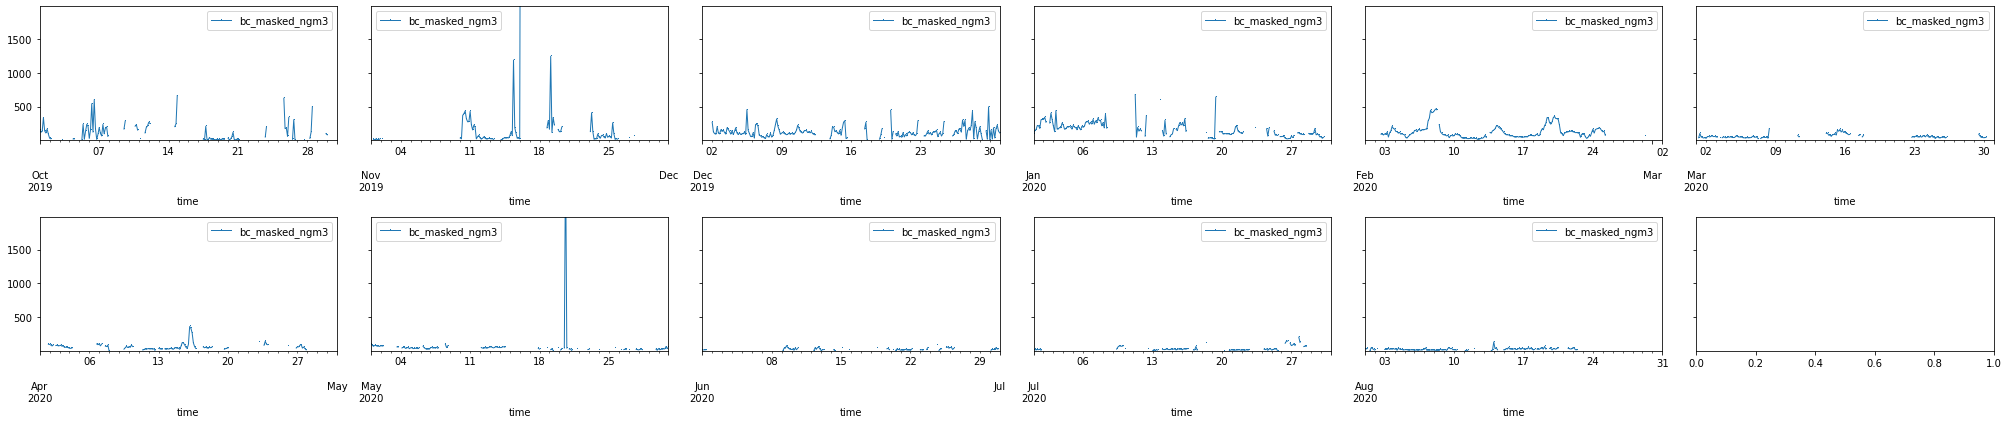

In [5]:
def plt_1(df,ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 5))
    df[[PAR]].resample('3H').mean().plot(ax=ax, marker=',', lw=1)
    
def mplt(df):
    qm,qM = df[PAR].quantile([0,.999])
    f,axs = plt.subplots(2,6,sharey=True,figsize=(28,6))
    axf =axs.flatten()
    mm = df.index.min()
    mM = df.index.max()

    ms = [m.strftime('%Y-%m') for m in pd.date_range(mm, mM, freq='M')]
    for i,m in enumerate(ms):
        plt_1(df.loc[m],ax=axf[i])
        ax = axf[i]
        m_ = pd.to_datetime(m)+pd.Timedelta(30,'D')
#         print(m_)
        ax.set_xlim(pd.to_datetime(m), m_)
        ax.set_ylim(qm,qM)
#         ax.set_yscale('symlog',linthresh=1e5,linscale=.1)
#         ax.set_yticks([0,*[a*10**5 for a in range(1,10)],1e5,1e6,1e7])
    f.tight_layout()

mplt(df)

(0.0, 8295.430943944973)

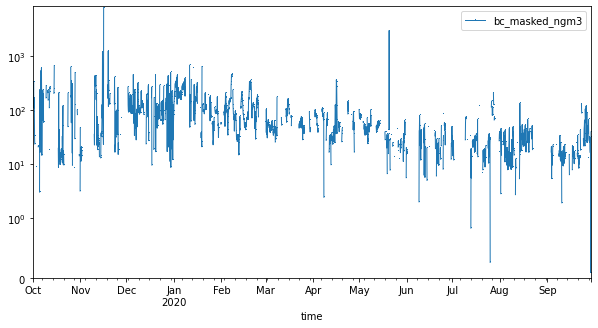

In [6]:
plt_1(df)
plt.gca().set_yscale('symlog',linthresh=1)
plt.gca().set_ylim(0,None)

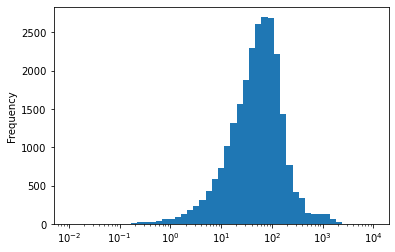

In [7]:
def _plt_dist(df):
    (df[PAR]).plot.hist(bins=np.geomspace(.01, 10000))
    plt.gca().set_xscale('log')
_plt_dist(df)

# open and merge flex 200 or 1000 clusters

In [8]:
ds = xr.open_dataset(PATH_200_CLUS)

In [9]:
def _merge_ds_and_df(ds,df):
    dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

    df1 = df

    df2 = df1.resample('3H').median()

    dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")
    return dm,dsf 
dm,dsf = _merge_ds_and_df(ds,df)

# 1st CV Inverse modeling elastic NET

0.0028022033565213633 0.5


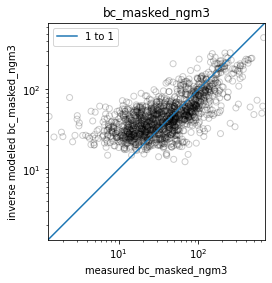

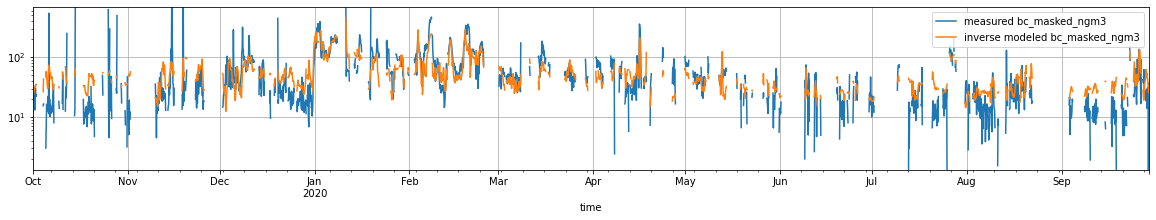

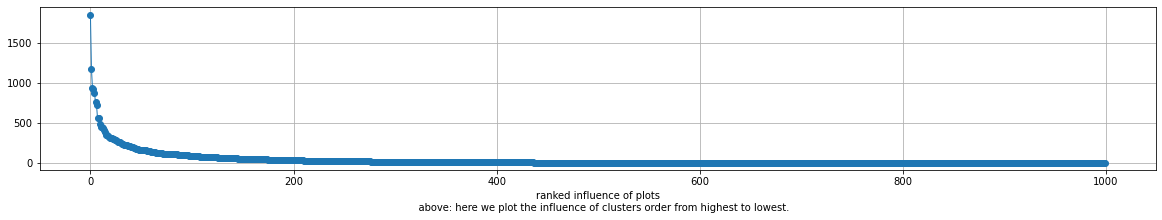

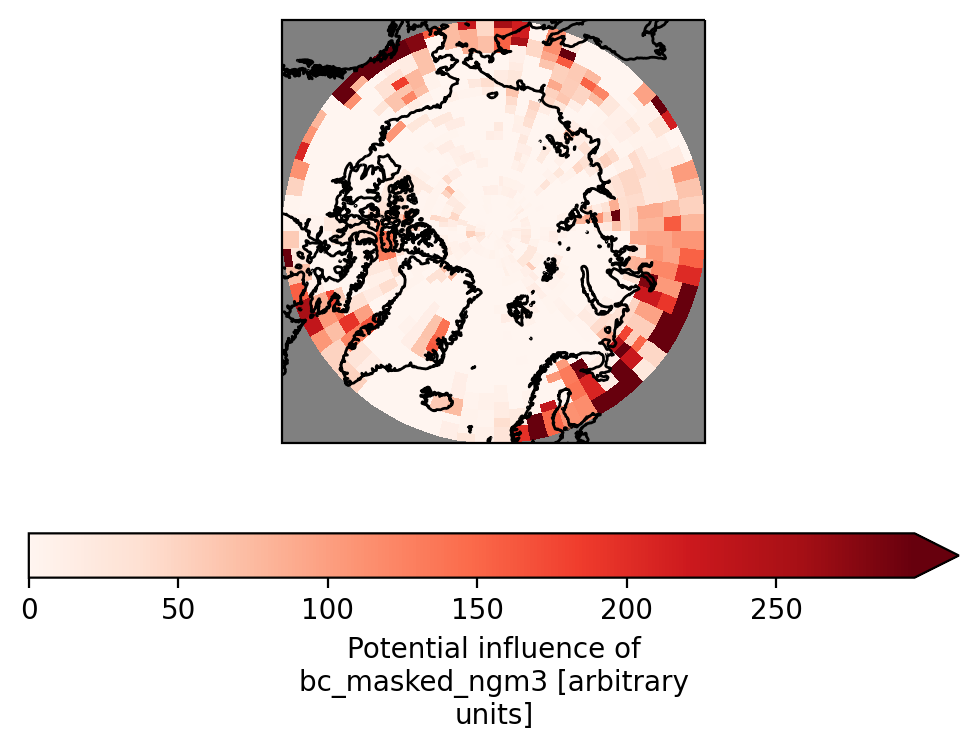

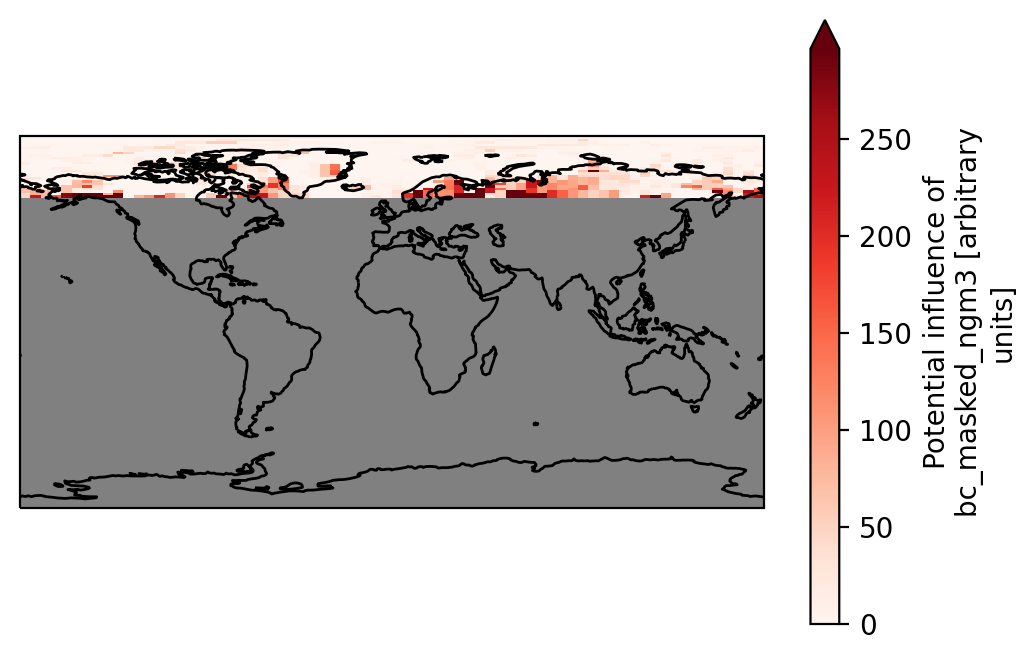

In [10]:
# for PAR in [SA,MSA,IA]:
def plt_el_net(dsf,dm):
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net(dsf,dm)

In [11]:
pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

0.0028022033565213633 0.5


In [12]:
def get_rat(dp,y,yn):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression(fit_intercept=True).fit(dp[yn].to_frame(),y[yn])
    
    r2 = lr.score(dp[yn].to_frame(),y[yn])
    coef = lr.coef_.item()
    inte = lr.intercept_

    return r2,coef, inte
r2, rat,inte = get_rat(dp,y,yn)
rat, r2,inte

(1.1663589477539062, 0.369352411160198, -4.112747)

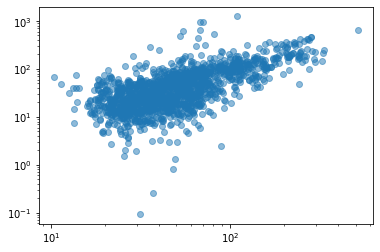

In [13]:
plt.scatter(dp[yn]*rat+inte,y[yn],alpha=.5)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

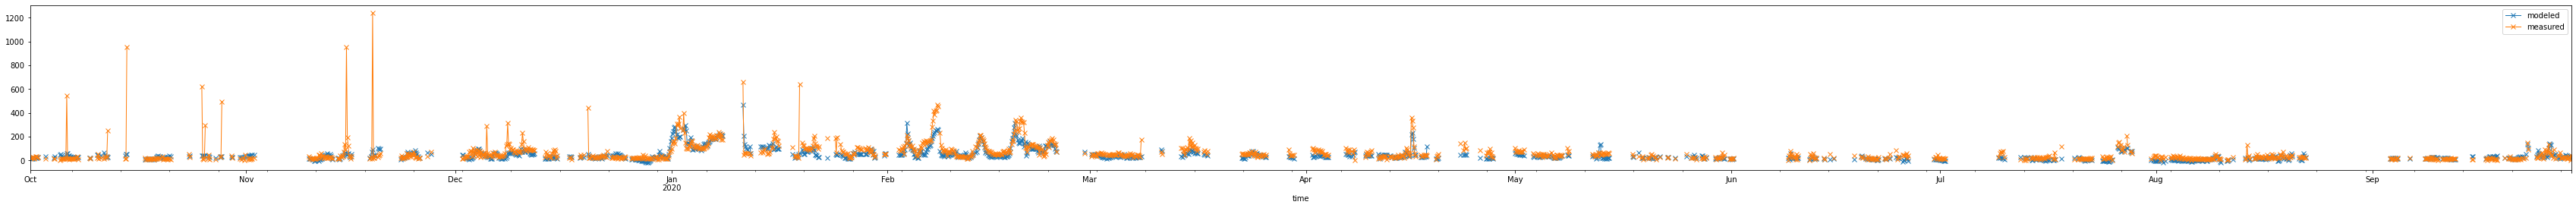

In [14]:
def _plot(rat,dm,dsf,cdf,y, inte):
    # AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf*rat+inte))
    __ = _.sum(axis=1)[yn].resample('3H').mean()
    __.plot(lw=1,marker='x', label = 'modeled')
    plt.gcf().set_figwidth(60)
#     plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
#     plt.gca().set_ylim(0,None)
    y[yn].resample('3H').mean().plot(lw=1,marker='x', label = 'measured')
    plt.gca().legend()

_plot(rat,dm,dsf,cdf,y,inte)

In [15]:
def get_contr(rat,dm,dsf,cdf,A,yn,inte):
    _cdf = cdf>0
#     AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf * rat+inte))[yn].T.where(_cdf).T
    __ = _.sum(axis=0)
    a =  __.sort_values()[::-1].cumsum()/__.sum()
    __ = __.where(a<A,0)
    return __

contr =  get_contr(rat,dm,dsf,cdf,1,yn,inte)

In [16]:
contr

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
          ...    
995    172.043945
996      0.000000
997    251.216125
998    234.819733
999    473.741547
Length: 1000, dtype: float32

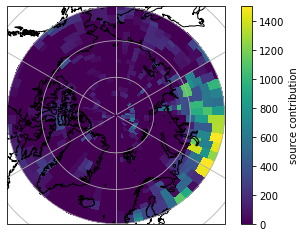

In [17]:
def _plt(ds,contr,ax=None):
    import matplotlib as mpl
    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

    _1 = ds['lab'].to_dataframe()['lab'].iloc[:, 1].replace(contr.to_dict()).to_xarray()
    _1.name = 'source contribution'

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    _1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0)


_plt(ds,contr)

In [18]:
N=20

def _clus(dm,dsf,cdf,contr,ds,yn,rat,inte, N ):
#     N = 20

    from sklearn.cluster import KMeans

    contrs_ = (dm[dsf.columns] * (cdf*rat + inte)).T.where(contr > 0, 0).T[yn]

    _norm = np.sqrt((contrs_ ** 2).sum())

    _nn = contrs_ / _norm
    _nn1 = _nn.dropna(axis=1)

    km = KMeans(N, random_state=123)

    _l = km.fit_predict(_nn1.T.values) + 1

    _l1 = pd.Series(_l, index=_nn1.T.index)
    _nl = (_norm * 0 + _l1)

    def _reorder_by_inf(_nl, contrs_):
        i_ = contrs_.T.groupby(_nl).sum().T.sum().sort_values()[::-1].reset_index()['index']
        i_.index = i_.index + 1
        _order = {v: i for i, v in i_.items()}
        _nl = _nl.replace(_order)
        return _nl

    _nl = _reorder_by_inf(_nl, contrs_)

    d_ = ds['lab'].to_series().replace(_nl.to_dict()).to_xarray()
    d_.name = 'sorted_inf_clusters'
    return d_, contrs_, _nl


(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds,yn,rat,inte,N)





In [19]:
a = regr.alpha_
l = regr.l1_ratio_

In [20]:
a,l

(0.0028022033565213633, 0.5)

In [21]:
def _plot_clust_infs(contrs,nl,dsf,cdf,y, rat,dm,inte,yn,N):
    AA = 1
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    for i in range(1, N+1):
        (AA*clus_ts[i]).plot(c=plt.get_cmap('tab20')(i - 1),lw=5)
    plt.gcf().set_figwidth(60)
    plt.gca().legend()
    #plt.gca().set_yscale('symlog')

    #(contrs.T.groupby(nl).sum().sum()*rat).plot(c='.7', ls='--', marker='D')

    def plt_model(dm):
        _ = dm[dsf.columns] * (cdf * rat + inte)
        __ = _.sum(axis=1)
        __[yn].resample('3H').mean().plot(lw=1, marker='+', label='modeled', alpha=.5, c='k')

    plt_model(dm)

    y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5)

    plt.legend()
    ymin, ymax = y[yn].quantile([0,.999])
#     plt.gca().set_ylim(ymin,ymax)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_32447/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


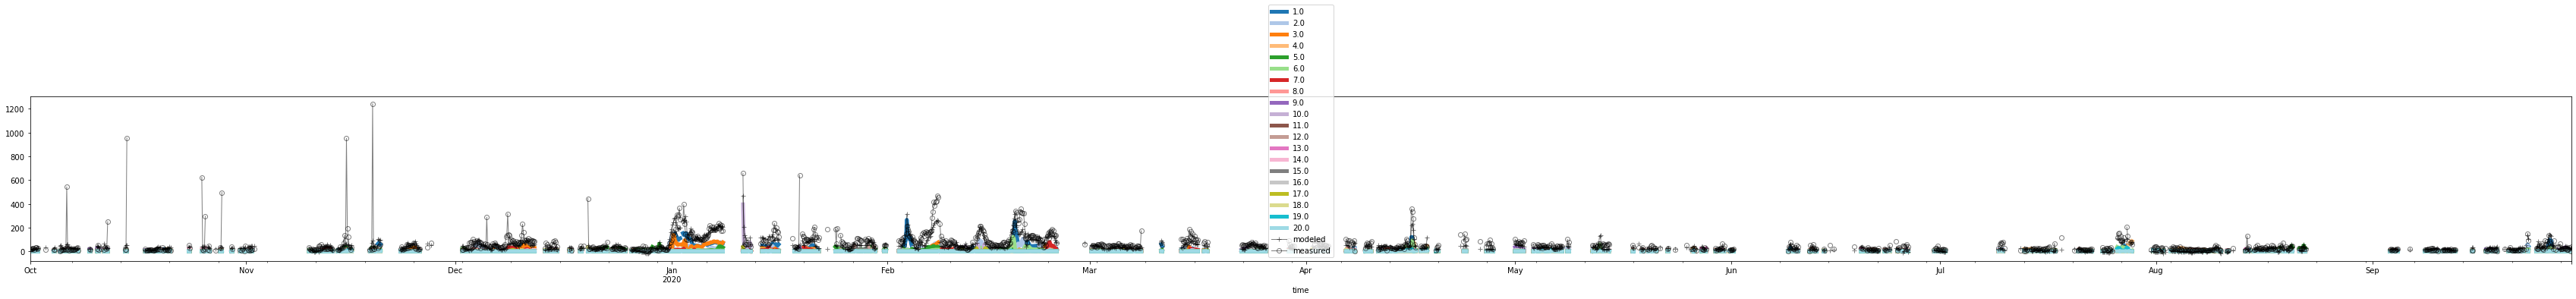

In [22]:
_plot_clust_infs(contrs,nl,dsf,cdf,y, rat, dm,inte,yn,N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_32447/4144042222.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


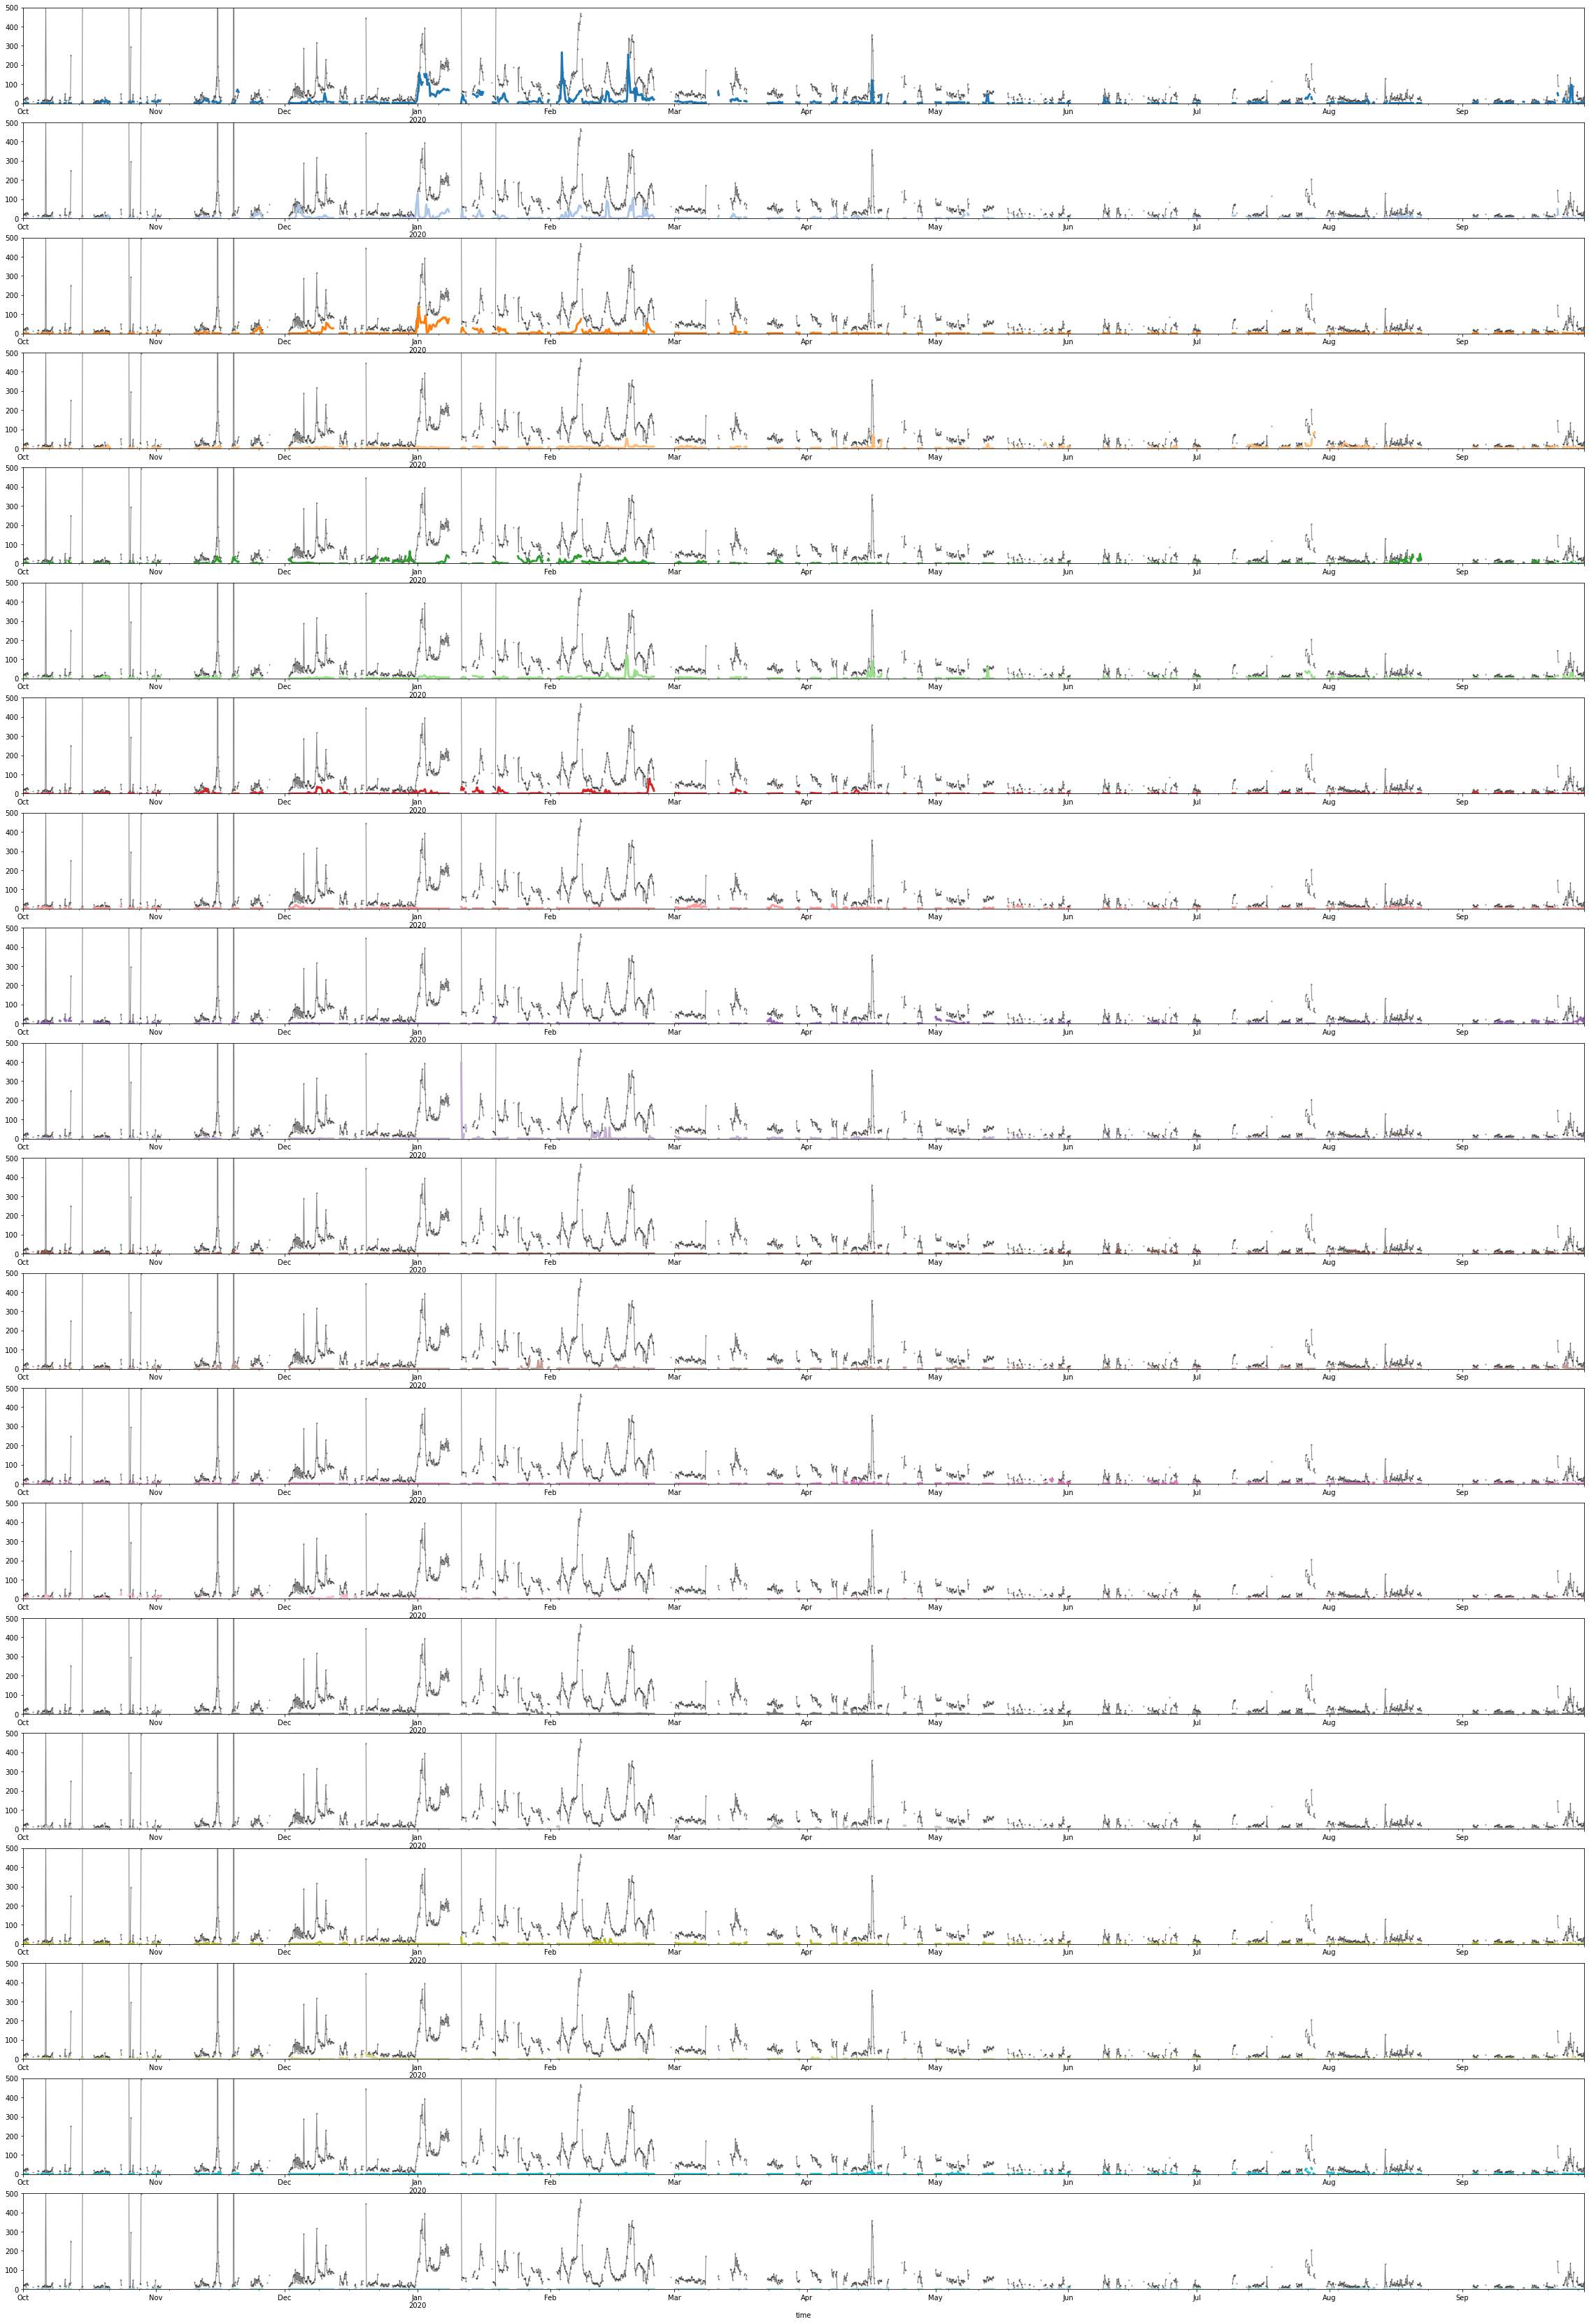

In [23]:
def plot_single_contrs(contrs, nl, yn,y, N):
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    f, axs = plt.subplots(N, 1, figsize=(40, 3 * 20), sharey=True)
    axf = axs.flatten()
    for i in range(1, N+1):
        y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5, ax=axf[i - 1],
                                         ms=1)
        clus_ts[i].plot(ax=axf[i - 1], c=plt.get_cmap('tab20')(i - 1), lw=3)
        axf[i - 1].set_ylim(0, 500)

plot_single_contrs(contrs, nl, yn,y, N)

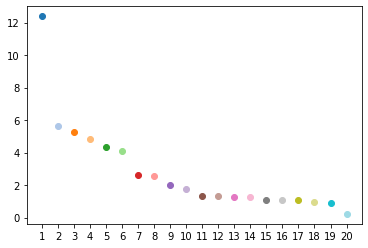

In [24]:
def plt_contrs(contrs,nl,N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,N):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl,N)

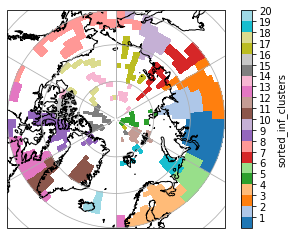

In [25]:
def _plt_influence_clusters(ds):
    import matplotlib as mpl
    _,ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    (ds['sorted_inf_clusters']-.5).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='tab20',
                                        cbar_kwargs={'ticks':range(1,21)},
                                        vmin=0,vmax=20)
_plt_influence_clusters(ds)

# multi elastic net 

In [26]:
l

0.5

In [27]:
aa = np.geomspace(a/100,2,36)
CC = 20
LL = l

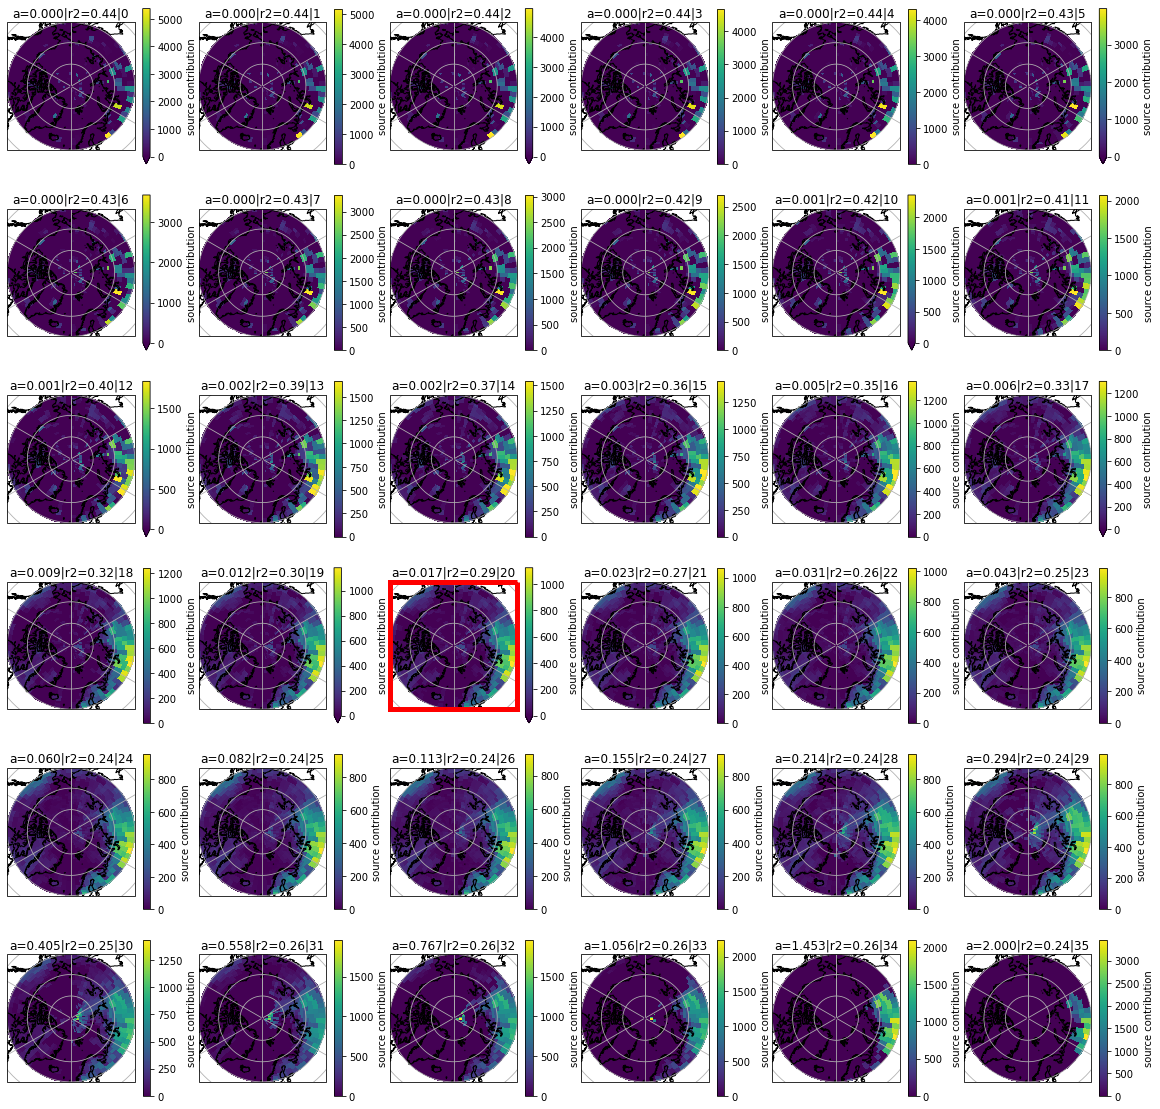

In [28]:
def elastic_net_reg3(dsf, dm, PAR, a, l ):
    from sklearn.linear_model import ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt(  (X ** 2).sum()  ) ** (1/1)
    XX = X.divide(xn, axis=1)
    #############


    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    regr = ElasticNet(a,l1_ratio=l, random_state=123, positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

#     print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr

def _multi_plot(aa,CC):
    
    f,axs = plt.subplots(6,6,figsize=(20,20),subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    axf = axs.flatten()
    
    for i_,a_ in enumerate(aa):
        ax = axf[i_]
        pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,a_,LL)
        r2, rat, inte = get_rat(dp,y,yn)
        contr = get_contr(rat,dm,dsf,cdf,1,yn,inte)
        _plt(ds,contr,ax)
        ax.set_title(f'a={a_:.3f}|r2={r2:.2f}|{i_}')
        if i_ == CC:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(5)
_multi_plot(aa,CC)

# chosen elastic net 

In [29]:
pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,aa[CC],LL)
r2, rat, inte = get_rat(dp,y,yn)

In [30]:
LL,aa[CC]

(0.5, 0.016632041553028158)

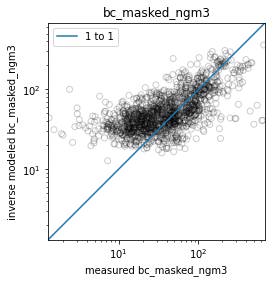

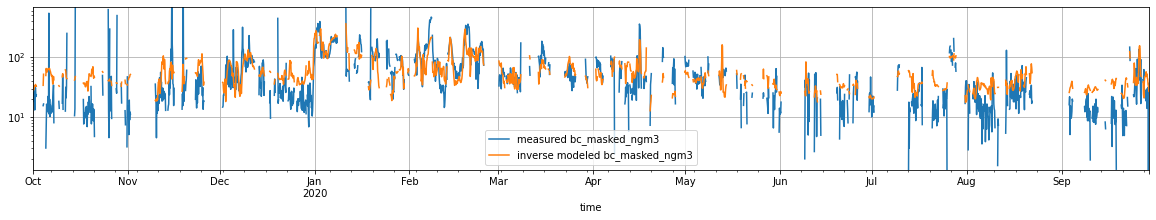

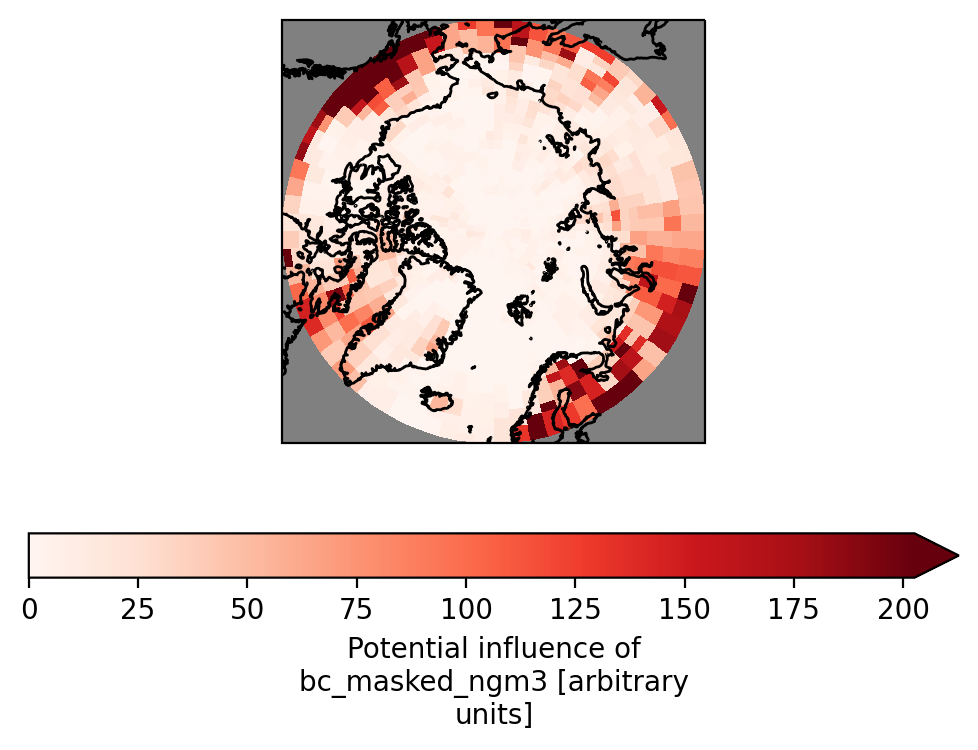

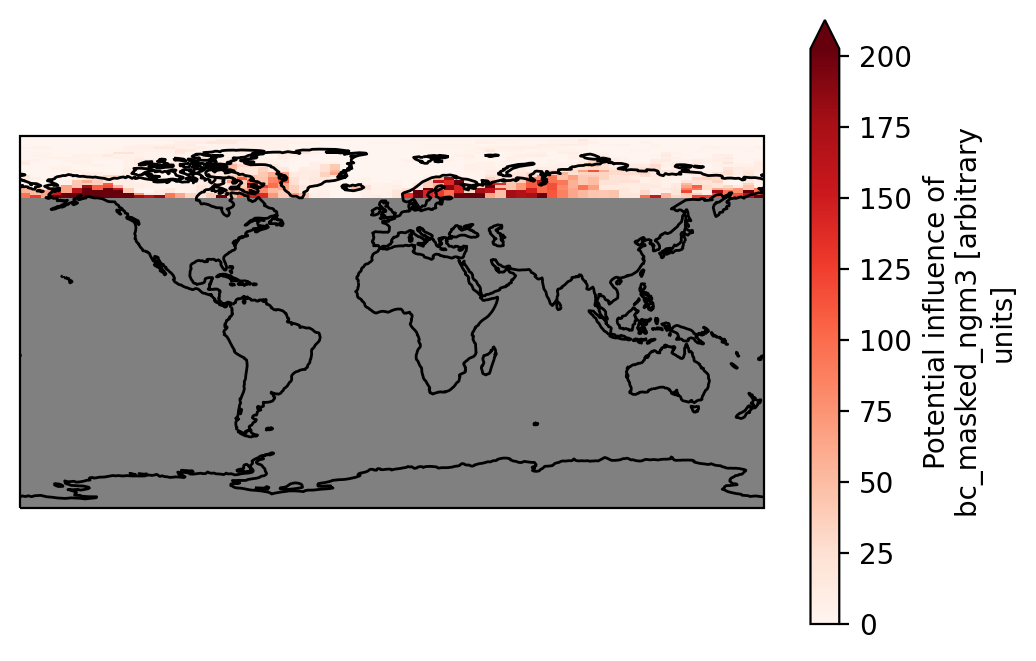

In [31]:
# for PAR in [SA,MSA,IA]:
def plt_el_net():
    
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred*rat+inte, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp*rat+inte, pred*rat+inte, MEA, MOD)
    #rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net()

In [32]:
N = 20
contr = get_contr(rat,dm,dsf,cdf,1, yn,inte)

(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds, yn, rat , inte, N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_32447/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


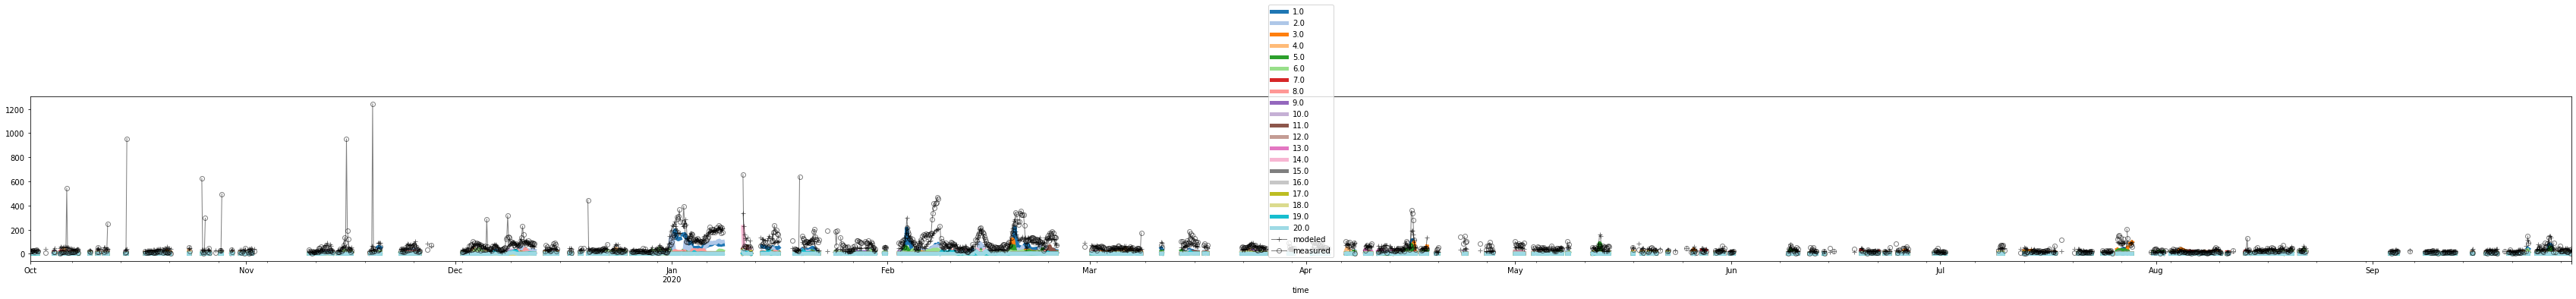

In [33]:
_plot_clust_infs(contrs=contrs,nl=nl,dsf=dsf,cdf=cdf,y=y, rat=rat, dm=dm, inte=inte, yn=yn,N=N)

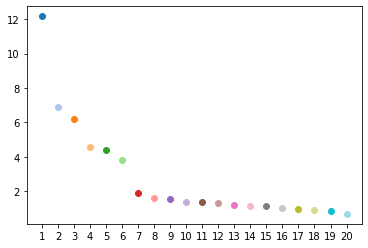

In [34]:
def plt_contrs(contrs,nl):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,20):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl)

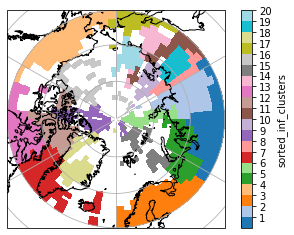

In [35]:
_plt_influence_clusters(ds)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_32447/4144042222.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


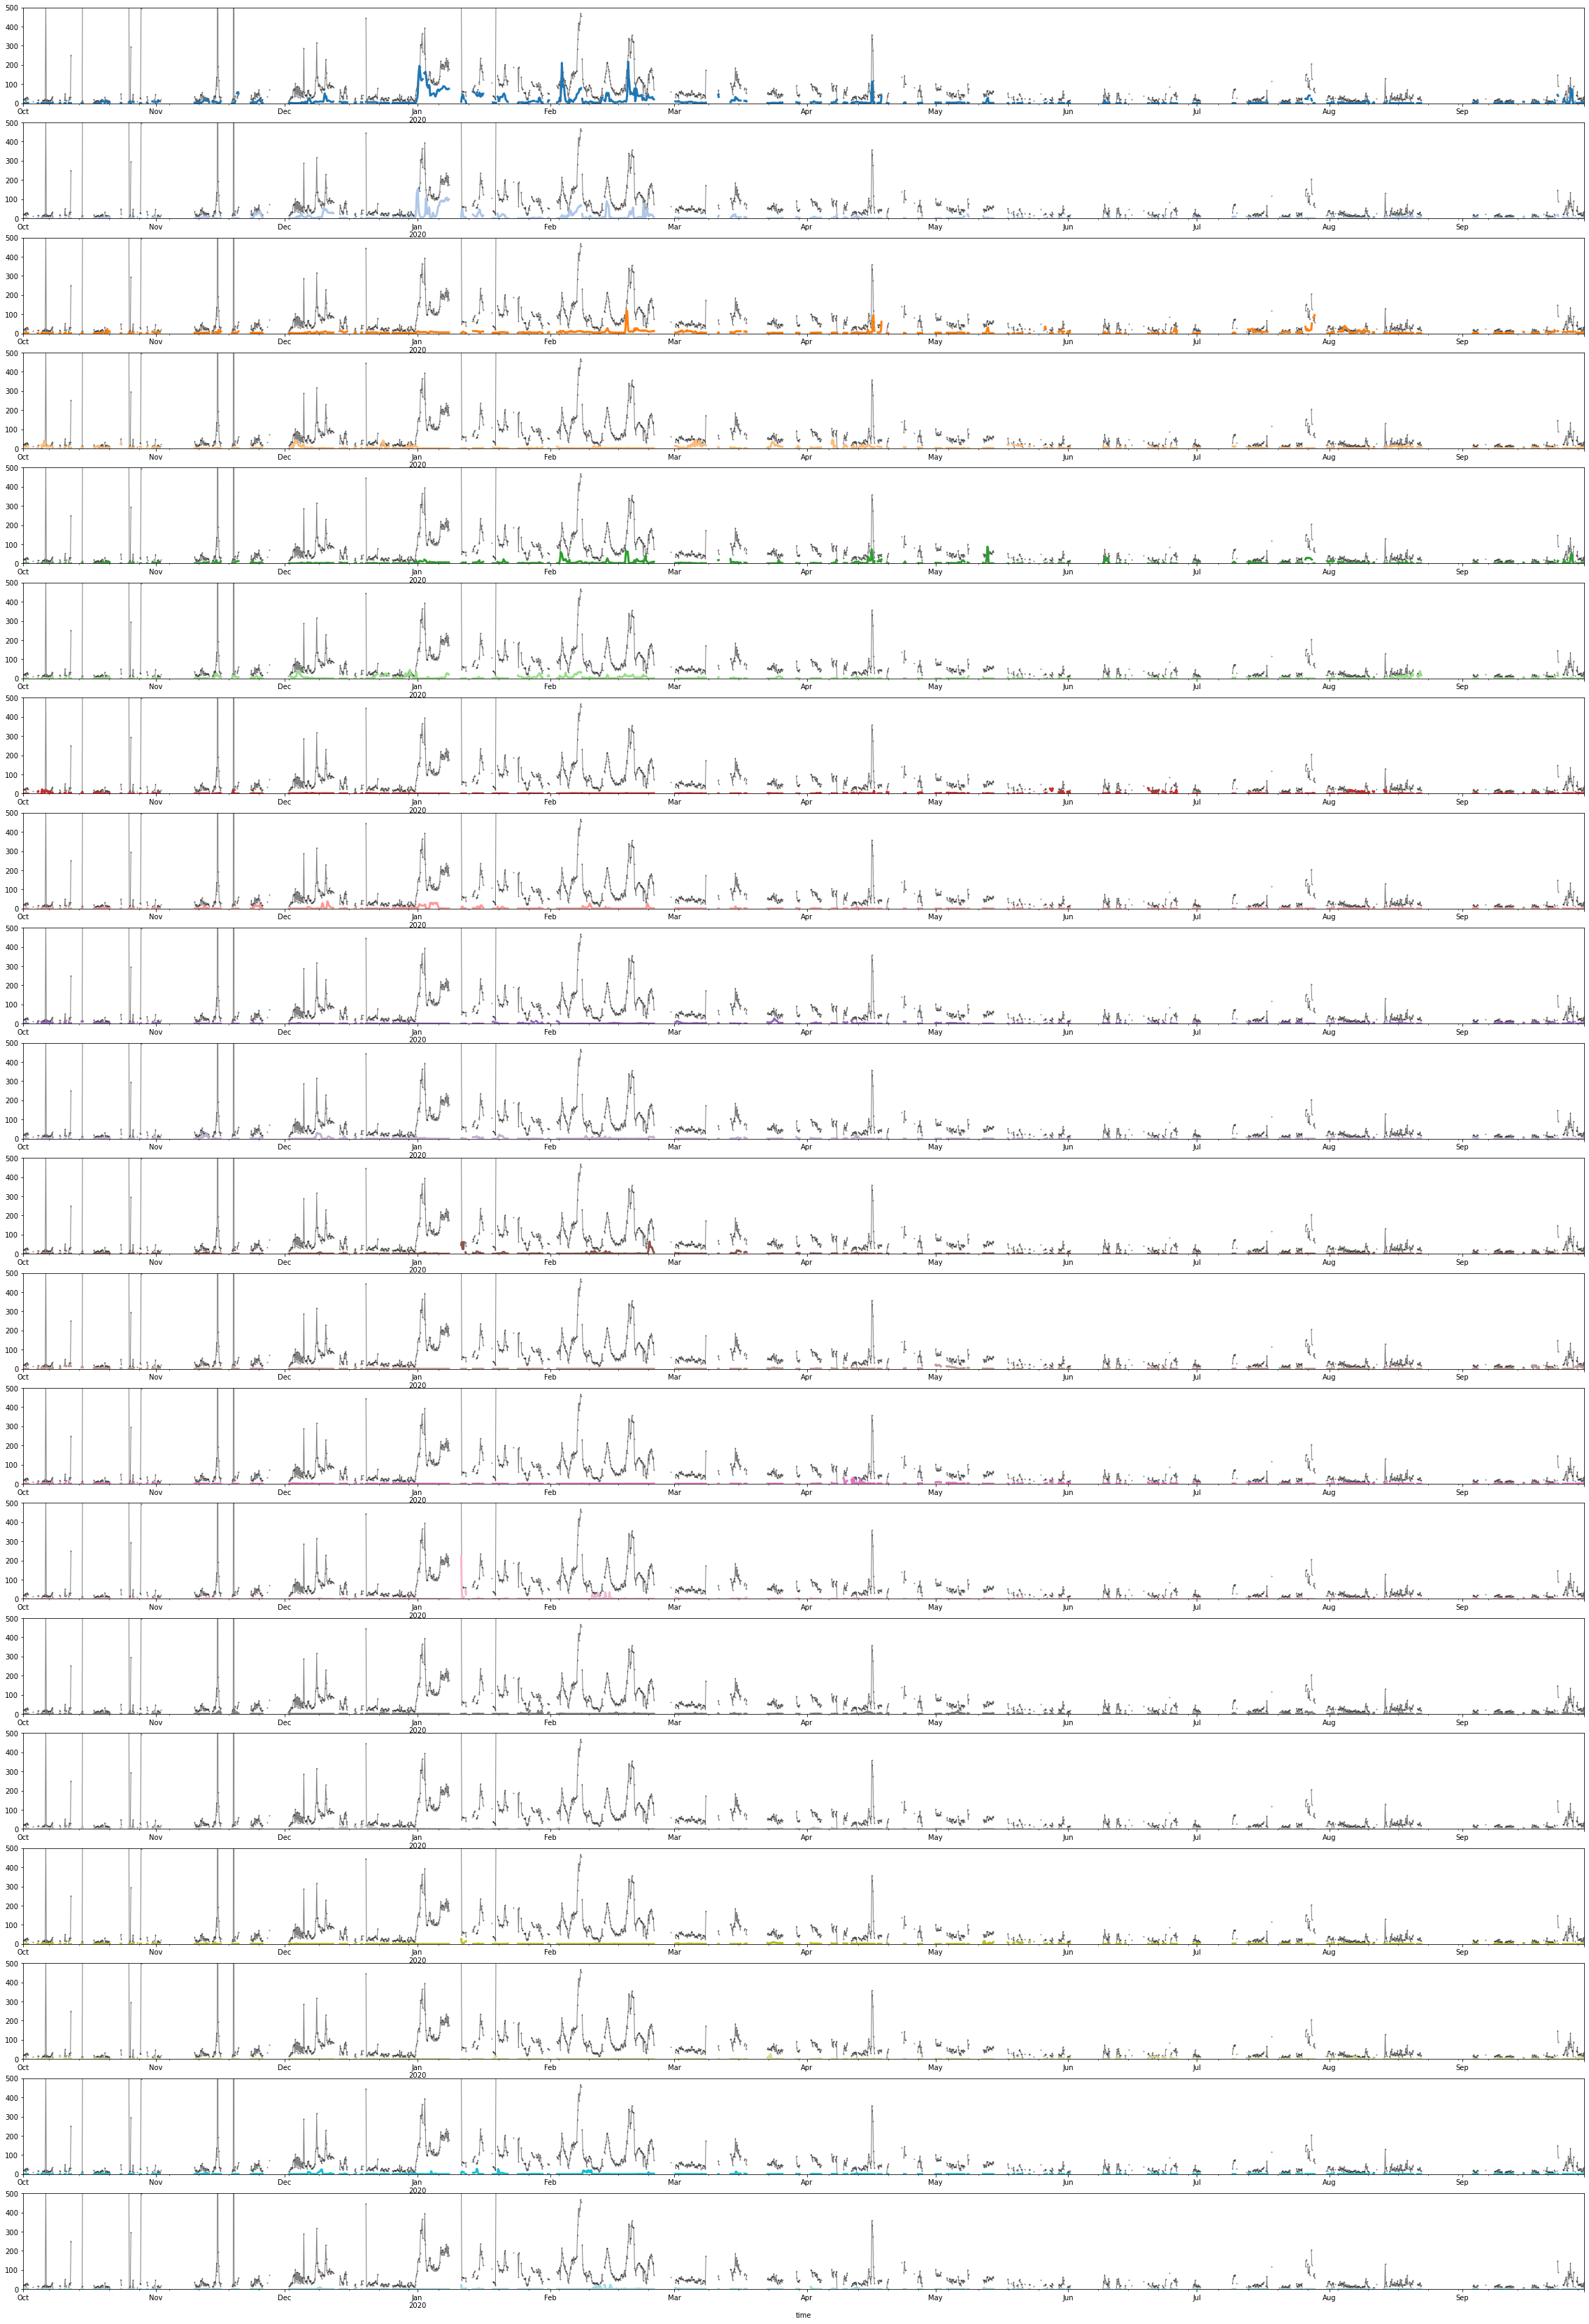

In [36]:
plot_single_contrs(contrs, nl, yn,y,N)

# save data

In [37]:
clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_32447/2478368837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


In [38]:
clus_ts

1.0       2.0       3.0       4.0       5.0   \
time                                                                    
2019-10-01 00:00:00  1.483068  0.584237  2.721808  9.486087  0.577031   
2019-10-01 03:00:00  1.749105  0.552527  2.853793  8.105582  0.547633   
2019-10-01 06:00:00  1.756526  0.529108  2.879452  8.284920  0.573681   
2019-10-01 09:00:00  1.741571  0.538452  2.854444  8.716020  0.622013   
2019-10-01 12:00:00  1.834395  0.541776  2.715613  9.132933  0.603099   
...                       ...       ...       ...       ...       ...   
2020-09-29 00:00:00  4.541889  1.381338  4.975983  4.480111  3.293272   
2020-09-29 03:00:00  4.180640  1.165113  4.836149  4.609066  3.016122   
2020-09-29 06:00:00  4.946812  1.075392  5.333632  2.890185  3.680382   
2020-09-29 09:00:00  5.701266  1.352332  5.368355  2.961046  3.182371   
2020-09-29 12:00:00  3.401836  0.851316  4.607211  2.852606  2.712798   

                         6.0       7.0       8.0       9.0       10.0  \
time                                                                    
2019-10-01 00:00:00  1.892044  0.651294  0.426885  1.607121  2.253066   
2019-10-01 03:00:00  1.881219  0.347150  0.275449  1.381170  1.482507   
2019-10-01 06:00:00  1.697343  0.338110  0.231487  1.301503  1.273304   
2019-10-01 09:00:00  1.686194  0.389491  0.199529  1.273955  1.181567   
2019-10-01 12:00:00  1.761111  0.416563  0.203529  1.294101  1.263687   
...                       ...       ...       ...       ...       ...   
2020-09-29 00:00:00  0.773603  1.447967  0.216797  2.284189  0.256425   
2020-09-29 03:00:00  0.610314  1.453490  0.171933  1.846732  0.214353   
2020-09-29 06:00:00  0.617002  1.382118  0.141777  1.346467  0.179152   
2020-09-29 09:00:00  0.597221  1.154224  0.285227  1.369603  0.341279   
2020-09-29 12:00:00  0.619270  1.586016  0.114756  0.962280  0.158124   

                         11.0      12.0      13.0      14.0      15.0  \
time                                                                    
2019-10-01 00:00:00  0.492446  0.600826  2.223528  0.782164  0.166084   
2019-10-01 03:00:00  0.334458  0.246304  1.023273  0.284316  0.406325   
2019-10-01 06:00:00  0.367331  0.227125  0.856315  0.293322  0.522883   
2019-10-01 09:00:00  0.419759  0.282092  0.927981  0.279633  0.619483   
2019-10-01 12:00:00  0.458514  0.360862  1.024905  0.316592  0.671710   
...                       ...       ...       ...       ...       ...   
2020-09-29 00:00:00  0.370074  8.674891  0.838293  0.393344  0.834057   
2020-09-29 03:00:00  0.257268  7.517535  0.857108  0.336088  0.752597   
2020-09-29 06:00:00  0.166918  4.189173  0.709716  0.179733  0.634213   
2020-09-29 09:00:00  0.203315  2.555894  0.604573  0.206617  0.601656   
2020-09-29 12:00:00  0.112787  2.197964  0.749872  0.109185  1.384356   

                         16.0      17.0      18.0      19.0      20.0  
time                                                                   
2019-10-01 00:00:00  0.644510  0.453112  0.131799  0.112319  5.647911  
2019-10-01 03:00:00  0.489102  0.347971  0.067208  0.100984  3.916108  
2019-10-01 06:00:00  0.597247  0.393387  0.064137  0.105624  3.490896  
2019-10-01 09:00:00  0.961461  0.383816  0.073658  0.112538  3.416353  
2019-10-01 12:00:00  1.857905  0.396076  0.098921  0.116785  3.778682  
...                       ...       ...       ...       ...       ...  
2020-09-29 00:00:00  0.568395  0.271599  4.780663  0.087164  0.134558  
2020-09-29 03:00:00  0.525067  0.253457  6.280049  0.079158  0.133789  
2020-09-29 06:00:00  0.743738  0.168593  3.029510  0.068366  0.171637  
2020-09-29 09:00:00  0.937318  0.137400  1.285298  0.107483  0.790129  
2020-09-29 12:00:00  0.276822  0.108512  1.905369  0.052717  0.116281  

[2917 rows x 20 columns]

In [39]:
clus_ts.to_csv(OUT_FILE)

In [40]:
fu.compressed_netcdf_save(ds,OUT_DS_FILE)

In [41]:
contrs.to_csv(OUT_CONTRS_FILE)

In [42]:
yn.to_csv(OUT_MEAS_FILE)